<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/04_transfer_learning_in_tensorflow_pt2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Pt2 Fine Tuning

In the previous notebook, we covered Feature Extraction. Now we'll cover another kind of Transfer Learning - Fine Tuning.

In [2]:
!nvidia-smi

Tue Feb 21 15:45:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we created a bunch of helper functions. Rather than tediously rewriting them, we're going to learn how to import functions.

🔑 **Note**: If you're running this notebook in Google Colab, when it times out, Colab will delete the script and you'll have to redownload it (re-run !wget).

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-02-21 15:45:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-21 15:45:15 (98.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Let's get data

This time we're going to see how we can use the pretrained models in tf.keras.applications and apply them to our own problem (recognizing images of food)
https://keras.io/api/applications/

In [5]:
# Get 10% training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-21 15:45:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  38.3MB/s    in 4.7s    

2023-02-21 15:45:24 (33.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("/content/10_food_classes_10_percent.zip")

In [7]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("/content/10_food_classes_10_percent")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_10

In [8]:
# Create training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

`image_dataset_from_directory()`:

This is going to replace the `ImageDataGenerator` because it creates a `tf.data.Dataset` which is a handy tf datatype. You don't need to create a `datagen` and then apply it to the path_dir.

In [9]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

`BatchDataset` : means the function has changed data into batches. `None` leaves a dimension in the tensor for different batches.
The labels are one-hot encoded.

In [11]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.25867348e+01 3.25867348e+01 3.05867348e+01]
   [3.20000000e+01 3.20000000e+01 3.20000000e+01]
   [3.24285736e+01 3.20000000e+01 3.42142868e+01]
   ...
   [3.66428566e+01 3.14285927e+01 2.90713844e+01]
   [3.03570900e+01 2.53570900e+01 2.23570900e+01]
   [2.30560646e+01 1.80560646e+01 1.50560656e+01]]

  [[3.14030609e+01 3.14030609e+01 2.94030609e+01]
   [3.10714283e+01 3.10714283e+01 3.10714283e+01]
   [3.24285736e+01 3.20000000e+01 3.42142868e+01]
   ...
   [3.91428375e+01 3.39285736e+01 3.15713634e+01]
   [3.35713768e+01 2.85713768e+01 2.55713768e+01]
   [2.48570385e+01 1.98570385e+01 1.68570385e+01]]

  [[3.00000000e+01 3.00000000e+01 2.80000000e+01]
   [3.07295914e+01 3.07295914e+01 3.07295914e+01]
   [3.24285736e+01 3.20000000e+01 3.42142868e+01]
   ...
   [4.04285278e+01 3.52142639e+01 3.28570557e+01]
   [3.82142487e+01 3.32142487e+01 3.02142467e+01]
   [2.99998608e+01 2.49998608e+01 2.19998608e+01]]

  ...

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2

# Building a features extraction model with the Keras Functional API

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order. The Functional API gives more flexibility with our models.

In [13]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to add our own output layer

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input (shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2, you will need to normalize inputs.
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs into the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after global average pooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
print(f"Shape after output layer: {x.shape}")

# 8. Combine the inputs wiht the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent, 
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                   experiment_name="model_0")])




16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling2D: (None, 1280)
Shape after output layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20230221-154541


Epoch 1/5
24/24 [==============================] - 28s 460ms/step - loss: 1.9063 - accuracy: 0.3800 - val_loss: 1.3213 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 5s 176ms/step - loss: 1.1078 - accuracy: 0.7720 - val_loss: 0.8515 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 4s 167ms/step - loss: 0.7855 - accuracy: 0.8387 - val_loss: 0.6692 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 4s 146ms/step - loss: 0.6460 - accuracy: 0.8627 - val_loss: 0.5944 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 4s 143ms/step - loss: 0.5409 - accuracy: 0.8880 - val_loss: 0.5505 - val_accuracy: 0.8651


In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 0.5510 - accuracy: 0.8652


[0.551034152507782, 0.8651999831199646]

In [16]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [17]:
# how about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [18]:
# Summary of the entire model
model_0.summary()
# notice how efficientnetb0 is counted as a single layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


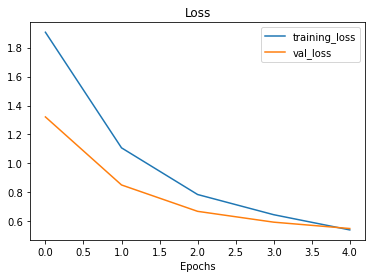

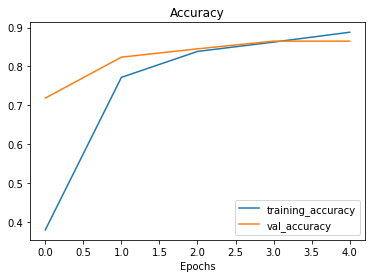

In [19]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the `GlobalAveragePooling2D` layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280). But after passing through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and pass it through `GlobalAveragePooling2D`.


In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass random_tensor through GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # note the syntax!
print(f"2D Global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global average pooled 2D tensor: (1, 3)


In [21]:
# Let's replicated the Global Average Pooled 2D Layer
tf.reduce_mean(input_tensor, axis=[1,2])
# reduces the tensor to the mean of the values across the axes 1 and 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🛠 Try to do the same with the above 2 cells but this time use `GlobalMaxPool2D`

In [22]:
input_shape = (1,4,4,3)
input_tensor = tf.random.normal(input_shape)
global_max_pool_2d_layer = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pooling_2d_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"The input tensor is:\n {input_tensor} \n")
print(f"The global max pool 2D layer is:\n {global_max_pool_2d_layer} \n")
print(f"The global max pooling 2D layer is:\n {global_max_pooling_2d_layer} \n")
print(f"The shape of the input tensor is: {input_tensor.shape}")
print(f"The shape of the global_max_pool_2D_layer is {global_max_pool_2d_layer.shape}")
print(f"The shape of hte global max pooling 2D layer is {global_max_pooling_2d_layer.shape}")

The input tensor is:
 [[[[ 8.4224582e-02 -8.6090374e-01  3.7812304e-01]
   [-5.1962738e-03 -4.9453196e-01  6.1781919e-01]
   [-3.3082047e-01 -1.3840806e-03 -4.2373410e-01]
   [-1.3872087e+00 -1.5488191e+00 -5.3198391e-01]]

  [[-4.4756433e-01 -2.0115814e+00 -5.7926011e-01]
   [ 5.7938927e-01  1.3041967e+00  6.7720258e-01]
   [-7.4587613e-01  1.0378964e+00  1.3820479e+00]
   [ 1.4319172e+00 -3.7643117e-01  9.8158473e-01]]

  [[-2.3597860e-01 -3.3763257e-01 -8.9593250e-01]
   [ 4.2754072e-01 -3.8105518e-01  4.7006992e-01]
   [ 3.5413779e-02 -2.9272759e+00 -9.6707004e-01]
   [-4.1402709e-01 -4.0137586e-01  6.2328768e-01]]

  [[-9.3648863e-01  9.5449388e-01  4.9025390e-01]
   [-9.9804848e-01 -1.1686406e+00 -6.7897290e-01]
   [ 1.7331039e+00  7.8643024e-01  9.2237018e-02]
   [ 2.2711790e-01 -9.1896124e-02  1.1224977e+00]]]] 

The global max pool 2D layer is:
 [[1.7331039 1.3041967 1.3820479]] 

The global max pooling 2D layer is:
 [[1.7331039 1.3041967 1.3820479]] 

The shape of the input t

### What is a feature vector?

A learned represenation of the input data (a compressed form of the input data) based on how the model sees it. 

# Running a seris of transfer learning experiments

We've seen the incredible results transfer learning gets with 10% of the training data bue how does it go with 1% of the training data? We will set up a bunch of experiments to investigate this...

1. `model_1`: use feature extraction on 1% of the training data with data augmentation.
2. `model_2`: use feature extraction on 10% of the training data with data augmentation.
3. `model_3`: use fine tuning on 10% of the training data with data augmentation.
4. `model_4`: use fine tuning on 100% of the training data with data augmentation.

🔑 **Note**: the test_data is consistent through all experiments.


## `model_1`:Feature extraction on 1% of the data with augmentation.


### Getting the data

In [23]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("/content/10_food_classes_1_percent.zip")

--2023-02-21 15:47:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  39.3MB/s    in 3.8s    

2023-02-21 15:47:04 (33.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [24]:
walk_through_dir("/content/10_food_classes_1_percent/")

There are 2 directories and 0 images in '/content/10_food_classes_1_percent/'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1_percent/t

In [25]:
# Set up data loaders
train_dir = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           image_size=(224,224),
                                                                           batch_size=32,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into the model, we can use the layers:
* tf.keras.layers.experimental.preprocessing()

Benefits of doing data augmentation inside the model:
* Happens on the GPU (faster) rather than the CPU.
* It is only turned on during training, so this layer is "off" when the model is running a prediction i.e. the test data is not augmented. 

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [27]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet60 has Rescaling
], name="data_augmentation")

#### Visualize our data augmentation layer

(-0.5, 537.5, 423.5, -0.5)

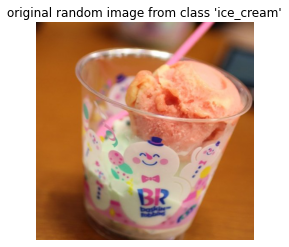

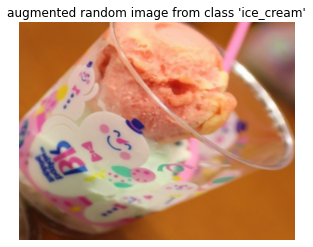

In [28]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "/content/10_food_classes_1_percent/train/" + target_class # remember this is a string
random_image=random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class '{target_class}'")
plt.axis(False)

# Now let's plot our augmented random image
plt.figure()
augmented_img = data_augmentation(img)
plt.imshow(tf.cast(augmented_img, dtype=tf.int32)) 
# the code in parenthesis converts the float numbers to integers (0-255) for matplotlib. 
# alternative code converst it to floats between 0 and 1
# plt.imshow(augmented_img/255.)
plt.title(f"augmented random image from class '{target_class}'")
plt.axis(False)



### Creating the model

In [56]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
inputs = data_augmentation(inputs, training=False)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(inputs)
# # Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model_1.summary()

# # Fit the model
history_1 = model_1.fit(train_data_1_percent, 
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                   experiment_name="model_1")]
)



Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug 

79/79 [==============================] - 6s 70ms/step - loss: 1.6810 - accuracy: 0.5468


[1.6809910535812378, 0.5468000173568726]

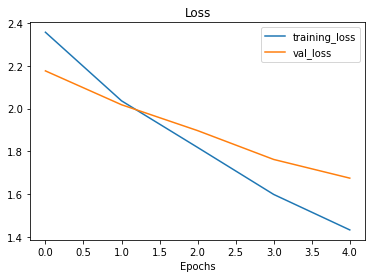

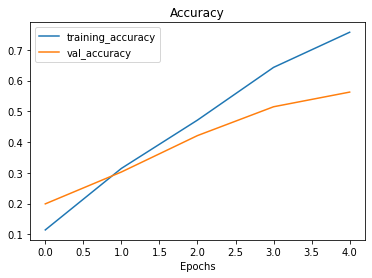

In [31]:
# Evaluate loss curves
plot_loss_curves(history_1)

## `model_2`: feature extraction on 10% of the data with augmentation

### Getting the data

In [32]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-02-21 15:47:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 4.5s    

2023-02-21 15:47:54 (35.5 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [33]:
unzip_data("10_food_classes_10_percent.zip.1")

In [34]:
walk_through_dir("/content/10_food_classes_10_percent/")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent/'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/content/10_food_classes_1

In [35]:
train_dir="/content/10_food_classes_10_percent/train/"
test_dir="/content/10_food_classes_10_percent/test/"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=(224,224),
                                                                             batch_size=32,
                                                                             label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation

In [61]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2)
    
], name="data_augmentation")

### Creating the model

In [70]:
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
input = keras.layers.Input (shape=(224,224,3), name="input_layer")
x = data_augmentation(input)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(input,output)
model_2.summary()

model_2.compile (loss = "categorical_crossentropy", 
                 optimizer="Adam", 
                 metrics="accuracy")

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [ ]:
model_2.fit(train_data_10_percent, 
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback(dir_name="/content/transfer_learning",
                                                   experiment_name="model_2")])

Saving TensorBoard log files to: /content/transfer_learning/model_2_10percent_data_with_augmentation/20230221-161058
Epoch 1/5


24/24 [==============================] - 29s 804ms/step - loss: 2.0633 - accuracy: 0.2933 - val_loss: 1.5751 - val_accuracy: 0.6132
Epoch 2/5
24/24 [==============================] - 17s 699ms/step - loss: 1.3891 - accuracy: 0.6747 - val_loss: 1.1227 - val_accuracy: 0.7612
Epoch 3/5
24/24 [==============================] - 16s 662ms/step - loss: 1.0779 - accuracy: 0.7373 - val_loss: 0.9055 - val_accuracy: 0.7968
Epoch 4/5
24/24 [==============================] - 22s 895ms/step - loss: 0.9203 - accuracy: 0.7693 - val_loss: 0.7826 - val_accuracy: 0.8140
